# Development of a Train-Test-Set Splitting Strategy for the Structure SVM Evaluation

Aim is to find a strategy to sample test (MS, RT)-sequences from the individual datasets (e.g. AC_003) in the MassBank database (DB). The performance of the Structure Support Vector Machine (SSVM) model is evaluated based on those test sequences. 

In [157]:
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it
import scipy.stats as sp_stats

from sklearn.model_selection import KFold, ShuffleSplit

In [10]:
DB_FN = "../db/massbank__2020.11__v0.6.1.sqlite"
DB_FN_FULL = "../db/massbank__with_metfrag.sqlite"
DB_URI = "file:" + DB_FN + "?mode=ro"
DB_URI_FULL = "file:" + DB_FN_FULL + "?mode=ro"

DB_CONN_RO = sqlite3.connect(DB_URI, uri=True)
DB_CONN_RW = sqlite3.connect(DB_FN)
DB_CONN_FULL_RO = sqlite3.connect(DB_URI_FULL, uri=True)
DB_CONN_FULL_RW = sqlite3.connect(DB_FN_FULL)

## Visual Estimation of the Column Dead-times for 'UT_000' and 'CE_001'

Due to missing information on the chromatographic setup, the column dead-time could not be estimated for 'UT_000' and 'CE_001'. We use a visual inspection of the retention time (RT) histogram define a RT threshold (t_remove) below which we reject the (MS2, RT)-tuples. From the threshold we can calculate the dead-time (t_0).

Text(2.75, 67.5, '2.75 min')

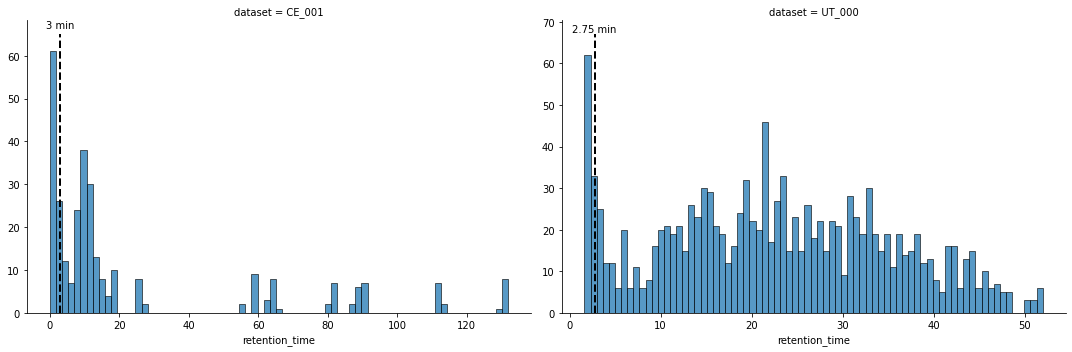

In [3]:
_query = \
    "select dataset, retention_time from spectra_rts" \
    "   inner join spectra_meta sm on sm.accession = spectra_rts.spectrum" \
    "   where dataset in ('CE_001', 'UT_000')"

g = sns.FacetGrid(data=pd.read_sql(_query, DB_CONN_RO), col="dataset", sharey=False, sharex=False, height=5, aspect=1.5)
g.map(sns.histplot, "retention_time", bins=75)

t_remove__CE_001 = 3  # min
g.axes[0, 0].vlines(t_remove__CE_001, 0, 65, color="black", linestyle="--", linewidth=2)
g.axes[0, 0].text(t_remove__CE_001, 66.5, "{} min".format(t_remove__CE_001), **{"horizontalalignment": "center"})

t_remove__UT_000 = 2.75  # min
g.axes[0, 1].vlines(t_remove__UT_000, 0, 67, color="black", linestyle="--", linewidth=2)
g.axes[0, 1].text(t_remove__UT_000, 67.5, "{} min".format(t_remove__UT_000), **{"horizontalalignment": "center"})

Visual inspection suggest the following retention time (RT) thresholds for the datasets:
- **CE_001**: 3 (min)
- **UT_000**: 2.75 (min)

From the threshold we calculate (estimate) the **column dead-time** values: t0 = t_remove / 3
- **CE_001**: t_0 = 1 (min)
- **UT_000**: t_0 = 0.917 (min)

In [9]:
with DB_CONN_RW:
    DB_CONN_RW.executemany(
        "UPDATE datasets SET column_dead_time_min = ? WHERE name = ?",
        [(1, "CE_001"), (2.75 / 3, "UT_000")]
    )
    
with DB_CONN_FULL_RW:
    DB_CONN_FULL_RW.executemany(
        "UPDATE datasets SET column_dead_time_min = ? WHERE name = ?",
        [(1, "CE_001"), (2.75 / 3, "UT_000")]
    )

## Statistics on the Number of (MS2, RT)-tuples per Dataset

Minimum number of (MS2, RT)-tuples:  39
Maximum number of (MS2, RT)-tuples:  911


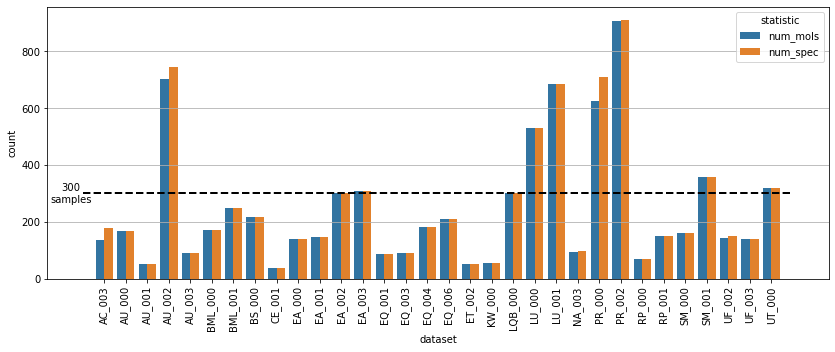

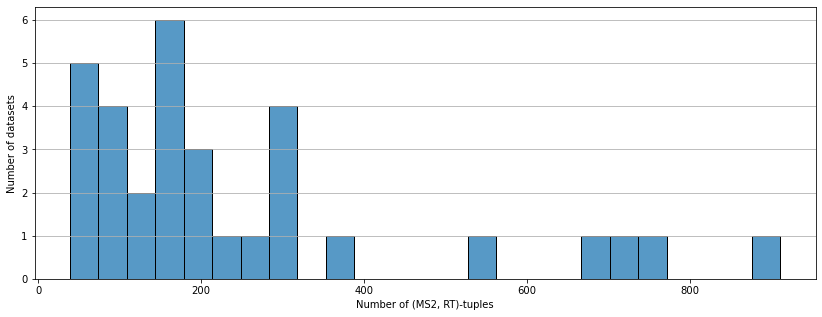

In [89]:
_query = \
    "select dataset, " \
    "       count(distinct molecule) as num_mols, " \
    "       count(accession) as num_spec" \
    "   from scored_spectra_meta" \
    "   inner join datasets d on d.name = scored_spectra_meta.dataset " \
    "   where retention_time >= 3 * column_dead_time_min "\
    "   group by dataset"

# Distribution of the Number of (MS2, RT)-tuples across datasets
fig = plt.figure(figsize=(14, 5))
ax = plt.gca()
sns.barplot(
    data=pd.read_sql(_query, DB_CONN_FULL_RO).melt(id_vars=["dataset"], var_name="statistic", value_name="count"),
    x="dataset", y="count", hue="statistic"
)
_min_n_spec = 300
ax.grid(axis="y")
ax.hlines(_min_n_spec, -1, 32, color="black", linestyle="--", linewidth=2)
ax.text(-2.5, _min_n_spec, "{}\nsamples".format(_min_n_spec), {"va": "center", "ma": "center"})
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

# Histogram of the Number of (MS2, RT)-tuples
fig = plt.figure(figsize=(14, 5))
ax = plt.gca()
sns.histplot(
    data=pd.read_sql(_query, DB_CONN_FULL_RO)[["dataset", "num_spec"]],
    x="num_spec", bins=25
)
ax.grid(axis="y")
ax.set_xlabel("Number of (MS2, RT)-tuples")
ax.set_ylabel("Number of datasets")

print("Minimum number of (MS2, RT)-tuples: ", pd.read_sql(_query, DB_CONN_FULL_RO)["num_spec"].min())
print("Maximum number of (MS2, RT)-tuples: ", pd.read_sql(_query, DB_CONN_FULL_RO)["num_spec"].max())

- For most datasets the number of (MS2, RT)-tuples matches the number of unique molecular structures
- The majority of the datasets has less then 200 (MS2, RT)-tuples
- The minimum respectively maximum number of (MS2, RT)-tuples are 39 respectively 911

## Developing a Test-sequence Sampling Strategy

In all following scenarios we use a **structured disjoint evaluation**. That means that every test molecular structure is removed from the training set regardless of its dataset association. Whether a test set molecule is in the training set is determined using the InChIKey-1 information, i.e. the 2D information of the molecule. Stereoisomers are therefore removed from the training set as well. 

### Leave-Dataset-Out (LDO)
**Pros**
- Multiple test-sequences (sampled from the left-out-dataset) can be predicted with the same SSVM model (reduced computation time)
- ...

**Cons**
- For large datasets (e.g. 'PR_002' with about 900 (MS2, RT)-tuples) a larger amount of training data must be removed (potential imbalance in the training sets)
- ...

#### Number of (MS2, RT)-Tuples per (target) Dataset in (LDO)

In [209]:
datasets, = zip(*DB_CONN_FULL_RO.execute("SELECT name FROM datasets").fetchall())

df_train = {}

for ds in datasets:
    accessions, molecules = zip(*DB_CONN_FULL_RO.execute(
        "SELECT accession, inchikey1 FROM scored_spectra_meta" \
        "   INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset " \
        "   INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule" \
        "   WHERE inchikey1 NOT IN (" \
        "      SELECT inchikey1 FROM scored_spectra_meta" \
        "         INNER JOIN molecules m1 ON m1.cid = scored_spectra_meta.molecule" \
        "         WHERE dataset IS ?" \
        "   )" \
        "     AND retention_time >= 3 * column_dead_time_min", (ds, )
    ).fetchall())
    
    molecules = set(molecules)  # get distinct structures
    assert len(accessions) == len(set(accessions))
     
    df_train[ds] = (set(accessions), molecules, len(accessions), len(molecules))
    
    print("Dataset '{}': num_spec={} and num_mols={} for training".format(ds, len(accessions), len(molecules)))

Dataset 'AC_003': num_spec=7844 and num_mols=3905 for training
Dataset 'AU_000': num_spec=7208 and num_mols=3869 for training
Dataset 'AU_001': num_spec=7697 and num_mols=3949 for training
Dataset 'AU_002': num_spec=5386 and num_mols=3340 for training
Dataset 'AU_003': num_spec=7737 and num_mols=3947 for training
Dataset 'BML_000': num_spec=7543 and num_mols=3867 for training
Dataset 'BML_001': num_spec=7414 and num_mols=3789 for training
Dataset 'BS_000': num_spec=7583 and num_mols=3831 for training
Dataset 'CE_001': num_spec=7874 and num_mols=3992 for training
Dataset 'EA_000': num_spec=7236 and num_mols=3892 for training
Dataset 'EA_001': num_spec=7202 and num_mols=3885 for training
Dataset 'EA_002': num_spec=6457 and num_mols=3729 for training
Dataset 'EA_003': num_spec=6444 and num_mols=3723 for training
Dataset 'EQ_001': num_spec=7778 and num_mols=3948 for training
Dataset 'EQ_003': num_spec=7747 and num_mols=3945 for training
Dataset 'EQ_004': num_spec=7534 and num_mols=3851 for

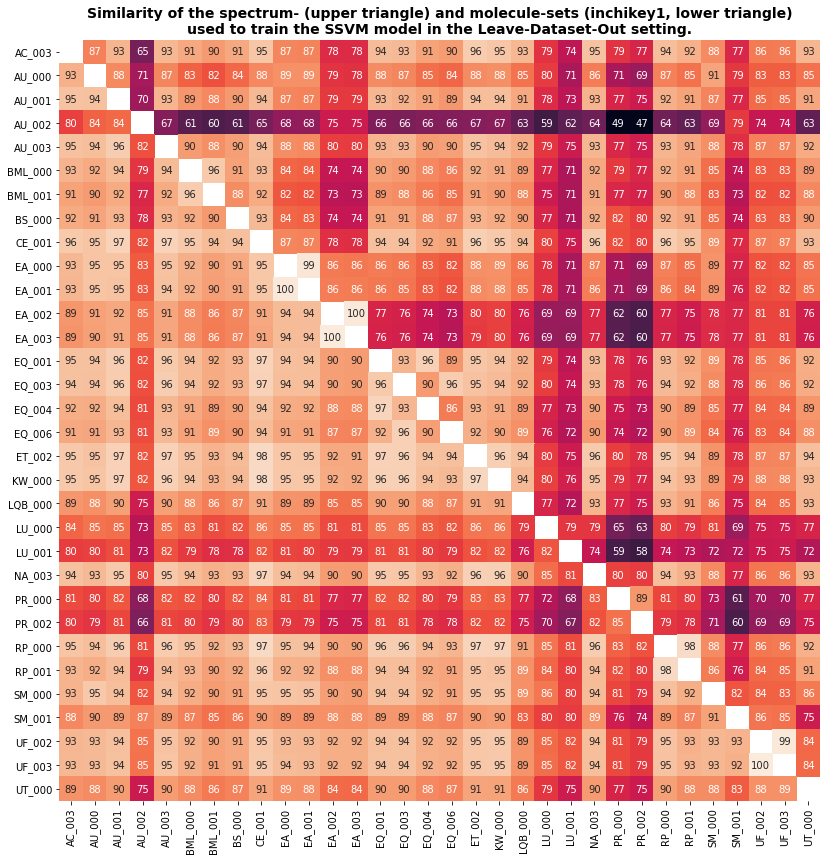

In [210]:
n_spec_total, n_mol_total = DB_CONN_FULL_RO.execute(
    "SELECT count(accession), count(distinct inchikey1) FROM scored_spectra_meta" \
    "   INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule"
).fetchone()

P = np.full((len(df_train), len(df_train)), fill_value=np.nan)

for r, (d1, v1) in enumerate(df_train.items()):
    for c, (d2, v2) in enumerate(df_train.items()):
        if c <= r:
            continue
    
        P[r, c] = len(v1[0] & v2[0]) / len(v1[0] | v2[0])  # goes to upper triangle matrix 
        P[c, r] = len(v1[1] & v2[1]) / len(v1[1] | v2[1])  # goes to lower triangle matrix
    
fig = plt.figure(figsize=(16, 14))
P = pd.DataFrame(P, index=df_train.keys())
P.columns = df_train.keys()
ax = sns.heatmap(P * 100, square=True, annot=True, fmt=".0f", cbar=False, vmin=50, vmax=100)
_ = ax.set_title(
    "Similarity of the spectrum- (upper triangle) and molecule-sets (inchikey1, lower triangle)\n" \
    "used to train the SSVM model in the Leave-Dataset-Out setting.",
    fontweight="bold", fontsize=14
)

##### Examples: 

###### 'AU_002' and 'PR_002':
- Only ~47% of the (MS2, RT)-tuples in the LDO setting are shared between the tranining sets of the SSVM models associated
  with the two datasets
- On the level of the molecular structures (determined based on InChIKey1) the overlap is ~66%
- Conlcusion: Training sets for 'AU_002' respectively 'PR_002' as target dataset are very different 

###### 'UF_003' and 'UF_002':
- Almost all the molecular structures and the (MS2, RT)-tuples are equal between the two training sets
- This can be explained if both datasets contain almost the same molecular structures (e.g. in positive and negative mode) 
  and therefore the same examples are removed from the overall training set
  
  
#### Discussion

- Having (very) different training sets leads to higher variance in the trained models
- This variance constributes to the variance in the performance estimate for each target dataset in the LDO setting
- There might be also a small bias introduced, as each training dataset removes eventually quite a lot of the overall 
  training data

### Leave-Tuples-Out (LTO)

**Pros**
- At most lenth-of-the-test-sequence many molecular structures are removed from the SSVM training set
- ...

**Cons**
- For each test-sequence a separate SSVM model must be trained (increased computation time) 
- ...

#### Number of (MS2, RT)-Tuples per (target) Dataset in LTO

In [215]:
datasets, = zip(*DB_CONN_FULL_RO.execute("SELECT name FROM datasets").fetchall())

df_train = {}

n_test_sets_total = 0

for idx, ds in enumerate(datasets):
    mols_ds, = zip(*DB_CONN_FULL_RO.execute(
        "SELECT distinct inchikey1 FROM scored_spectra_meta" \
        "   INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset" \
        "   INNER JOIN molecules m1 ON m1.cid = scored_spectra_meta.molecule" \
        "   WHERE dataset IS ?" \
        "     AND retention_time >= 3 * column_dead_time_min",
        (ds, )
    ))
    mols_ds = np.array(mols_ds)
    
    if len(mols_ds) <= 75:
        test_sets = [mols_ds]
    elif len(mols_ds) < 250:
        test_sets = [
            mols_ds[test_set]
            for _, test_set in ShuffleSplit(test_size=50, random_state=(idx * len(mols_ds)), n_splits=15).split(mols_ds)
        ]
    else:
        test_sets = [
            mols_ds[test_set]
            for _, test_set in KFold(n_splits=len(mols_ds) // 50, random_state=idx, shuffle=True).split(mols_ds)
        ]
    
    cts = np.zeros(len(mols_ds))
    for jdx, mol in enumerate(mols_ds):
        cts[jdx] += np.sum([np.isin(mol, test_set) for test_set in test_sets])
    
    print(
        "Dataset '{}': #mols={}, #sets={}, mean seq-len={}, #occ. of mol: med={}, min={} (==0 ={}), max={}".format(
            ds,
            len(mols_ds),
            len(test_sets),
            np.round(np.mean([len(test_set) for test_set in test_sets])), 
            np.median(cts), 
            np.min(cts),
            np.sum(cts == 0),
            np.max(cts)
        )
    )
    
    n_test_sets_total += len(test_sets)
    
    for test_set in test_sets:
        accessions, molecules = zip(*DB_CONN_FULL_RO.execute(
            "SELECT accession, inchikey1 FROM scored_spectra_meta" \
            "   INNER JOIN datasets d ON d.name = scored_spectra_meta.dataset " \
            "   INNER JOIN molecules m ON m.cid = scored_spectra_meta.molecule" \
            "   WHERE inchikey1 NOT IN %s" \
            "     AND retention_time >= 3 * column_dead_time_min" % ("(" + ",".join(["'%s'" % mol for mol in test_set]) +")")
        ).fetchall())

        molecules = set(molecules)  # get distinct structures
        assert len(accessions) == len(set(accessions))

        try:
            df_train[ds].append((set(accessions), molecules, len(accessions), len(molecules)))
        except KeyError:
            df_train[ds] = [(set(accessions), molecules, len(accessions), len(molecules))]
    
    print("Dataset '{}': num_spec={} and num_mols={} for training".format(
        ds, 
        np.round(np.mean([len(v[0]) for v in df_train[ds]])),
        np.round(np.mean([len(v[1]) for v in df_train[ds]]))
    ))
    
print("Total number of test-sets:", n_test_sets_total)

Dataset 'AC_003': #mols=132, #sets=15, mean seq-len=50.0, #occ. of mol: med=6.0, min=1.0 (==0 =0), max=11.0
Dataset 'AC_003': num_spec=7976.0 and num_mols=3987.0 for training
Dataset 'AU_000': #mols=168, #sets=15, mean seq-len=50.0, #occ. of mol: med=4.0, min=1.0 (==0 =0), max=9.0
Dataset 'AU_000': num_spec=7810.0 and num_mols=3987.0 for training
Dataset 'AU_001': #mols=50, #sets=1, mean seq-len=50.0, #occ. of mol: med=1.0, min=1.0 (==0 =0), max=1.0
Dataset 'AU_001': num_spec=7876.0 and num_mols=3987.0 for training
Dataset 'AU_002': #mols=694, #sets=13, mean seq-len=53.0, #occ. of mol: med=1.0, min=1.0 (==0 =0), max=1.0
Dataset 'AU_002': num_spec=7854.0 and num_mols=3984.0 for training
Dataset 'AU_003': #mols=90, #sets=15, mean seq-len=50.0, #occ. of mol: med=8.0, min=5.0 (==0 =0), max=13.0
Dataset 'AU_003': num_spec=7876.0 and num_mols=3987.0 for training
Dataset 'BML_000': #mols=168, #sets=15, mean seq-len=50.0, #occ. of mol: med=4.0, min=1.0 (==0 =0), max=8.0
Dataset 'BML_000': num_

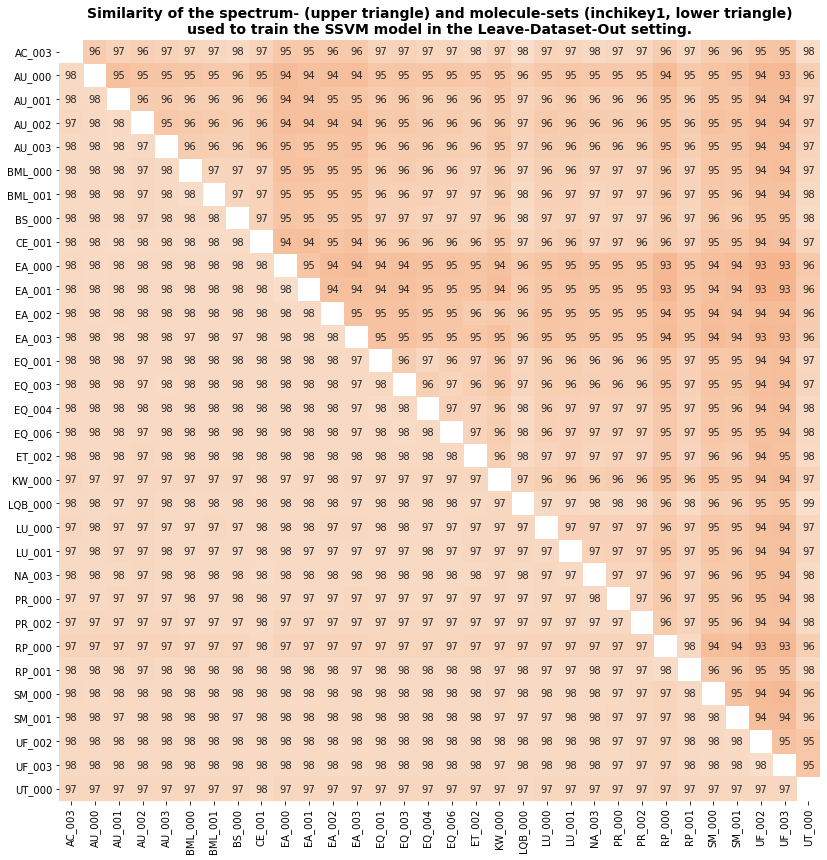

In [208]:
P = np.full((len(df_train), len(df_train)), fill_value=np.nan)

for r, (d1, v1) in enumerate(df_train.items()):
    for c, (d2, v2) in enumerate(df_train.items()):
        if c <= r:
            continue
    
        sim_acc = np.mean([len(v1i[0] & v2i[0]) / len(v1i[0] | v2i[0]) for v1i, v2i in zip(v1, v2)])
        sim_mol = np.mean([len(v1i[1] & v2i[1]) / len(v1i[1] | v2i[1]) for v1i, v2i in zip(v1, v2)])
    
        P[r, c] = sim_acc  # goes to upper triangle matrix 
        P[c, r] = sim_mol  # goes to lower triangle matrix
    
fig = plt.figure(figsize=(16, 14))
P = pd.DataFrame(P, index=df_train.keys())
P.columns = df_train.keys()
ax = sns.heatmap(P * 100, square=True, annot=True, fmt=".0f", cbar=False, vmin=50, vmax=100)
_ = ax.set_title(
    "Similarity of the spectrum- (upper triangle) and molecule-sets (inchikey1, lower triangle)\n" \
    "used to train the SSVM model in the Leave-Dataset-Out setting.",
    fontweight="bold", fontsize=14
)